Project: Titan Lightcurve - Polarization-phase curve

Author: Alex Medina

Organization: University of Central Florida

In [1]:
#General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

#Most important import, in order to read and manipulate image in .IMG or VICAR format
#The python package is called "rms-vicar"
import vicar
#The second most important package to use is called "opencv"
#Used to manipulate general images
#Not used in the brightness phase curves but to keep it consistent with the polarization phase curves
import cv2

Polarized images are created using the make_polar_virtual_machine.sav IDLVM script; with polarization being calculated by taking ratios in the iamges using different polarizers. However, this process has no knowledge of which pixels are on Titan and which pixels are not, so the entire image has polarization values. The values away from Titan are a combination of light spread beyond the limb from the point spread function, and noise in the CCD and possibly also some stray light if the camera is pointing close to Saturn or the Sun. So, to interpret the polarization image I needed to restrict my analysis to the disk of Titan, including pixels beyond the terminator since Titan’s extended atmosphere is lit by the sun over a large region beyond the geometric terminator. For the same reason, values in the theta image(for angle of linear polarization) should be ignored if they are not on the target.

For the $\frac{I}{F}$ images this was not critical since the intensity drops to near zero sufficiently far from the target, and you want to include intensity beyond the limb. To only consider pixels within the disk of Titan in the image, I used the python package, opencv. First, I create a copy of the image, to not mess with original strucure of the .IMG of .VIC images, and detect the disk or circle of Titan; after it is detected, the output is a pair of coordinates for the center of the disk. To define an effective radius for the disk of Titan, I just plot the total brightness of a circle centered on Titan for incresing radius and plot it: when the plot begins to plateau, pixels beyond this plateau are no relevant.

In [10]:
def image_center(image):
    #Creating a copy of the image to avoid messing with the original

    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    #Detect circle; I leave these parameters as is but they can be adjust to make circle detection more or less negative
    #I found that this is the best combination of parameters
    detected_circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=30, maxRadius=500)

    #If a circle is detected this will draw a circle and return center coordinates (x, y) with a radius a
    #But the radius is too rough, we determine it more accurately later, and we actually dont need to draw the circle
    if detected_circles is not None:
        detected_circles = np.round(detected_circles[0, :]).astype("int")
        for (x, y, r) in detected_circles:
            #Draw a cirlce of radius 1 around center to show center
            #cv2.circle(image_copy, (x, y), r, (0, 255, 0), 2)
            #Draw a circle of radius r around center to show radius
            #cv2.circle(image_copy, (x, y), 1, (0, 0, 255), 3)
            #Show the image
            #cv2.imshow(image_copy)
            #print({x}, {y})
            return (x, y)
    #Debug
    else:
        print("No circle found")
        return None

#To determine the effective radius, as mentioned, I plot the brightness against increasing radius
def radii_fluxes_from_image(image, center):
    x, y = center
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    #Each image is mach 1024 pixels wide, so set the maximum to 1000 to be safe
    radii = range(1, 1000, 5)
    flux = []

    for r in radii:
        mask = np.zeros_like(gray_image)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)

        #Applying mask to the image
        #Masking is one of the most important features that I take advantage of with opencv
        #This makes it so the circle of Titan is the ONLY part of the image that is showing and the rest is turned to either 0 or 1
        masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
        flux.append(np.sum(masked))
    return radii, flux

#Manual inspection and testing
def radii_fluxes_plot(radii, flux):
    plt.plot(radii, flux)
    plt.xlabel("Radius")
    plt.ylabel("Flux")
    plt.title("Flux vs. Radius")
    plt.show()

#To determine the effective radius, I originally used a gradient
#When the slope approaches 0, then that is a good point
#It works because Titan is really close to the Earth and the images have a lot of pixels
#But, in general, we don't have the luxury of so many pixels so just getting in the practice that this plateau point is determined when the difference between the current and previous pixel is...
#...much much less than the previous pixel
def effective_radius(radii, flux):
    for i in range(1, len(flux)):
        if flux[i] - flux[i-1] < 0.01 * flux[i-1]:
            return radii[i]
    #If no plateau is detected can return last radius
    #return radii[-1]

    #Debugging
    print("No plateau found")
    return None

Unlike brightness images where pixel units are in $\frac{I}{F}$, degree of linear polarization is unitless. To go from the intensity, polarization, and theta images to disk-integrated Q/I or polarization, I do a proper sum which takes into account how much each pixel contributes to the total. To give a little bit of background and starting with small assumptions; using Stokes vector, we define the degree of linear polarization(no circular polarization) as:

\begin{equation}
P = \frac{\sqrt{Q^2 + U^2}}{I}.
\end{equation}

Since each pixel has a calculated version of P, Q, and U, a more accurate representation is per pixel:

\begin{equation}
P_i = \frac{\sqrt{(Q_i)^2 + (U_i)^2}}{I_i}.
\end{equation}

So we can find the total degree of linear polarization by summing all pixels on Titan. In a simplified case, let's assume that there is no U, and there is only a Q component, when we can say:

\begin{equation}
P_i = \frac{Q_i}{I_i}.
\end{equation}

Which can be reworked as a weighted sum for total linear polarization or $\frac{Q}{I}$ as:

\begin{equation}
\frac{Q}{I} = P = \frac{\sum_{j} \frac{I_j}{F} P_j}{\sum_{j }\frac{I_j}{F}}.
\end{equation}

In [17]:
def simple_dlop(pol_image, IF_image, center, radius):
    #pol short for polarization images
    mask_pol = np.zeros_like(pol_image)
    #Fills the circle with 1s and the outside is 0
    #So that when we sum, we multiply the image by the mask, and the 0 multiplication gets rid of eveything outside of the disk
    #And everything inside the disk is summed but stays the same because multiplied by 1
    cv2.circle(mask_pol, center, radius, 1, thickness=-1)
    pol_masked = pol_image * mask_pol

    #ins short for I/F images
    mask_IF = np.zeros_like(IF_image)
    cv2.circle(mask_IF, center, radius, 1, thickness=-1)
    IF_masked = IF_image * mask_IF

    weighted = np.sum(IF_masked * pol_masked)
    total_IF = np.sum(IF_masked)

    return weighted / total_IF

Here, we input the path where the calibrated AND poalrized images are located. Of course, this is unique to my setup and the data that I have.

In [11]:
pol_images = r'C:\Users\Alex\Desktop\Titan\Polarized Images\GRN_P\GRN_POL'

#Have the same path
IF_images = r'C:\Users\Alex\Desktop\Titan\Polarized Images\GRN_P\GRN_POL'

pol_IF_metadata = r'C:\Users\Alex\Desktop\Titan\Polarized Images\GRN_P\GRN_POL\pol_data.csv'
#Reading the csv file
parameters_df = pd.read_csv(pol_IF_metadata)

Because we have to sort through different files in the same folder, it gets kinda messy, but here is a way to make it work: I can group the center and effectiv radius (x, y, r) and create a dictionary, in the folder there are three .VIC that correspond to the same image, hence they have the same beginning but different ending, i.e NXXXXXX_pol.vic and NXXXXXXX_I_over_F.vic, so we can match the corrdinates from the I_over_F coordinates to the _pol.vic images.

In [ ]:
#Grouping the circle center and radius for our dictionary
def find_circle_params(image_path):
    vic = vicar.VicarImage(image_path, strict=False)
    image = vic.data_2d
    center = image_center(image)
    radii, fluxes = radii_fluxes_from_image(image, center)
    eff_radius = effective_radius(radii, fluxes)
    return center, eff_radius

#Creating a dictionary with the opus_id being used as the key since it matches the polarized images and IF images
#And the corresponding center coordinates and effective radius are stored as the value

circle_params = {}
for filename in os.listdir(IF_images):
    if filename.endswith('_I_over_F.vic'):
        coordinate_image_path = os.path.join(IF_images, filename)
        opus_id = filename.split('_')[0]
        try:
            center, eff_radius = find_circle_params(coordinate_image_path)
            circle_params[opus_id] = (center, eff_radius)
            print(f'{filename}: {center}, {eff_radius}')
        #Debug
        except Exception as e:
            print(f"{filename}: {e}")

N1486913_I_over_F.vic: (np.int64(253), np.int64(263)), 181
N1494007_I_over_F.vic: (np.int64(447), np.int64(340)), 361
N1499415_I_over_F.vic: (np.int64(523), np.int64(523)), 371
N1515805_I_over_F.vic: (np.int64(517), np.int64(517)), 376
N1521214_I_over_F.vic: (np.int64(532), np.int64(527)), 391
N1526619_I_over_F.vic: (np.int64(478), np.int64(521)), 406
N1530756_I_over_F.vic: (np.int64(531), np.int64(506)), 361
N1534852_I_over_F.vic: (np.int64(490), np.int64(513)), 376
N1536147_I_over_F.vic: (np.int64(506), np.int64(511)), 401
N1537508_I_over_F.vic: (np.int64(512), np.int64(523)), 381
N1547135_I_over_F.vic: (np.int64(527), np.int64(514)), 401
N1549547_I_over_F.vic: (np.int64(512), np.int64(496)), 411
N1551056_I_over_F.vic: (np.int64(482), np.int64(495)), 381
N1553821_I_over_F.vic: (np.int64(518), np.int64(532)), 336
N1556523_I_over_F.vic: (np.int64(501), np.int64(551)), 391
N1557905_I_over_F.vic: (np.int64(484), np.int64(571)), 376
N1559282_I_over_F.vic: (np.int64(494), np.int64(560)), 3

Finally, we have a center and effective radius in order to mask the polarized image and calculate the total degree of linear polarization, or a simplified case of $\frac{Q}{I}$, and we already know the phase angle from the metadata. So this follows the exact same process as that of the brightness-phase curves, jsut with different naming conventions and a center and effective radius line.

In [19]:
#List lists for results
simple_dlops = []
phase_angles = []

#Because the .IMG calibrated images don't match 1:1 with the metadata, we have to do some fun things
#Same loop as before but additional if for center coords and radius
for filename in os.listdir(pol_images):
    if filename.endswith('_Pol.vic'):
    #if filename.endswith('_Theta.vic'):
    #if filename.endswith('_Q.vic'):
        pol_image_path = os.path.join(pol_images, filename)
        #Since these images are in .IMG(or .VIC) format, simple line to read image from rms-vicar package
        pol_vic = vicar.VicarImage(pol_image_path, strict=False)
        read_pol_image = pol_vic.data_2d

        #The coordinate images are also the _I_over_F.vic images just with that different ending
        #Removing that ending they have the exact same naming structure
        #Trying a replace, this works because _Pol.vic and _I_over_F.vic are both in the "polarized images" folder
        #I just named them differently for convenience
        IF_image_path = pol_image_path.replace('_Pol.vic', '_I_over_F.vic')
        IF_vic = vicar.VicarImage(IF_image_path, strict=False)
        read_IF_image = IF_vic.data_2d


        opus_id = filename.split('_')[0]
        #Comparatively, in the brightness-phase curve we used metadata file from OPUS, but here i created my own
        #So no need to add the prefix 'co-iss-' or change from upper to lowercase
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id)]

        #opus_id in circle_params becasue both I_over_F and pol images have same naming convention before the understore defined in circle params
        if opus_id in circle_params:
            center, eff_radius = circle_params[opus_id]

            if not parameter_row.empty:
                #Assocating the meta data with the image, pixel_scale and phase_angle
                phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]

                s_dlop = simple_dlop(read_pol_image, read_IF_image, center, eff_radius)

                #Creating array to plot
                phase_angles.append(phase_angle)
                simple_dlops.append(s_dlop)

                #For manual inspection
                print(f'{filename}: {s_dlop}')

N1486913_Pol.vic: 0.049955930560827255
N1494007_Pol.vic: 0.20695260167121887
N1499415_Pol.vic: 0.2633275091648102
N1515805_Pol.vic: 0.1329754889011383
N1521214_Pol.vic: 0.33118000626564026
N1526619_Pol.vic: 0.44710254669189453
N1530756_Pol.vic: 0.32857242226600647
N1534852_Pol.vic: 0.3191094994544983
N1536147_Pol.vic: 0.2692350447177887
N1537508_Pol.vic: 0.31137311458587646
N1547135_Pol.vic: 0.36123406887054443
N1549547_Pol.vic: 0.38702407479286194
N1551056_Pol.vic: 0.3021755814552307
N1553821_Pol.vic: 0.17862001061439514
N1556523_Pol.vic: 0.08891543000936508
N1557905_Pol.vic: 0.05651337653398514
N1559282_Pol.vic: 0.040823668241500854
N1567440_Pol.vic: 0.04534105211496353
N1570185_Pol.vic: 0.06248375400900841
N1571476_Pol.vic: 0.4098687767982483
N1577094_Pol.vic: 0.14538060128688812
N1579533_Pol.vic: 0.2592567503452301
N1582634_Pol.vic: 0.2569313943386078
N1585391_Pol.vic: 0.3266185522079468
N1617163_Pol.vic: 0.4305223822593689
N1617165_Pol.vic: 0.4434840977191925


Now, we have all the important information, an image (or data point) with a degree of a simplified $\frac{Q}{I}$ (y) and a phase angle(x).

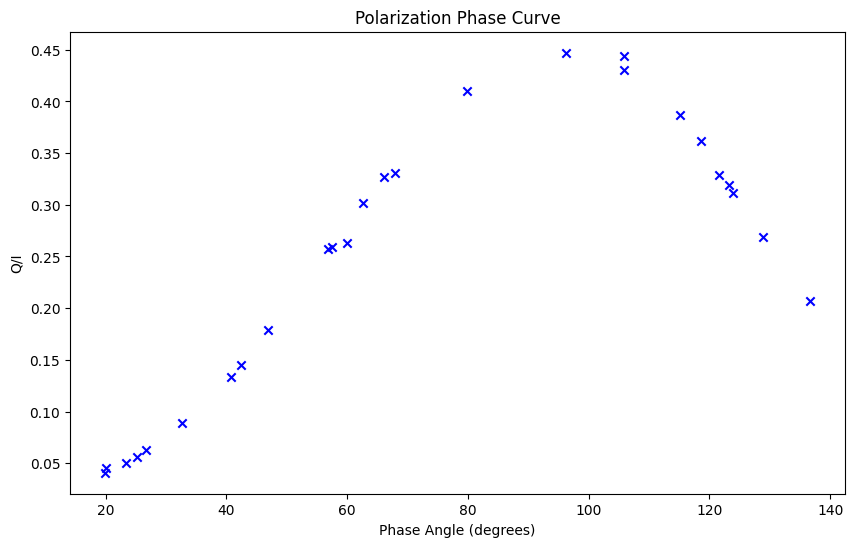

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_dlops, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q/I')
plt.title('Polarization Phase Curve')
plt.show()

Having examined outliers(explained in procedure), as a final step for consistency, I use the preliminary plot to gauge an idea for the maximum value. Hence, with this last section, I manually adjust the y axis height and tick number(at least divisible by 5). X-axis remains consistant across all filters.

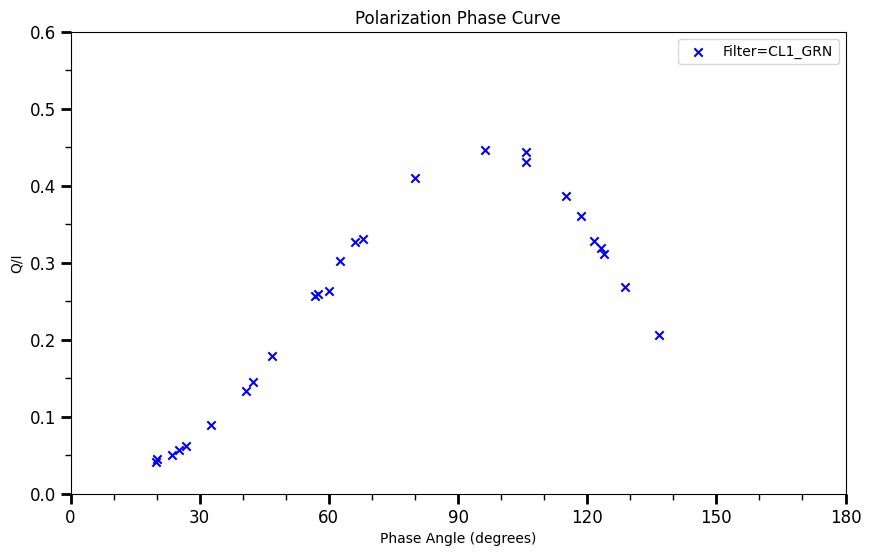

In [26]:
#Fancy plot for consistency across all plots but also visually will look better
filtername = 'CL1_GRN'

#Same as before
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, simple_dlops, color='b', marker='x', label=f'Filter={filtername}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel('Q/I')
plt.title('Polarization Phase Curve')

#x-ticks(phase angle) at every 10 ticks but a more pronounced tick at every 30 will be more pronounces
ax = plt.gca()
ax.set_xticks(range(0, 181, 30))
ax.set_xticks(range(0, 181, 10), minor=True)
ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=12)
ax.tick_params(axis='x', which='minor', length=4, width=1, labelsize=10)

#Same for the y-axis
#While the x-axis is phase so remains consistent
ay = plt.gca()
#Thicker ticks every 5
ay.set_yticks([i * 0.1 for i in range(7)], minor=False)
ay.set_yticks([i * 0.05 for i in range(60)], minor=True) 
plt.ylim(0, 0.60)

ay.tick_params(axis='y', which='major', length=7, width=2, labelsize=12)
ay.tick_params(axis='y', which='minor', length=4, width=1, labelsize=10)

plt.legend()
plt.show()

As a next step; ABOVE, we considered the case where U = 0, such that P = Q/I, but if there is both Q and U, we can determine and plot those individually.